1. <a href="#define functions">define functions</a>
2. <a href="#Define paths and capture data">Define paths and capture data</a>
3. <a href="#evaluate categorical features">evaluate categorical features</a>
4. <a href="#missing data">missing data</a>
5. <a href="#anomaly detection">anomaly detection</a>
6. <a href="#Visualize pairwise relations">Visualize pairwise relations</a>
7. <a href="#Check if data is imbalanced">Check if data is imbalanced</a>

In [44]:
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from impyute.imputation.cs import fast_knn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats

# %matplotlib inline
warnings.filterwarnings('ignore')

# set sandbox_mode boolean for image building
* if sandbox_mode = True: faster to run, but images won't be generated

In [45]:
sandbox_mode = False

# <a id="define functions">define functions</a>

In [46]:
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

### functions for visualizations

In [47]:
# build boxplots
def build_boxplots(df, x, file):
    
    plt.close()
    
    cols = df.columns
    fig, axes = plt.subplots(1,len(cols),figsize=(15,5))

    for ax,col in zip(axes, cols):
        sns.boxplot(x = x, y = col, data = df, ax = ax, width=.1)
    plt.tight_layout()
    plt.plot()
    
    # save file
    file = '01boxplot_'+file+'.jpg'
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")
    
# plot distributions
def plot_dist(feature, target, name, xlabel):
    fig, axes = plt.subplots(1,2,figsize=(15,5))
    ax1, ax2 = axes[0], axes[1]

    ax1 = sns.distplot( feature, hist=True, kde=True, bins=int(180/5), ax=ax1 )
    ax1.set_ylabel('frequency and KDE')
    ax1.set_xlabel(xlabel)
    ax1.set_title('{} histogram'.format(xlabel));

    ax2 = sns.kdeplot(feature[(target == 0) ],
                    color="Red", shade = True, ax = ax2)
    ax2 = sns.kdeplot(feature[(target == 1) ],
                    color="Blue", shade= True, ax = ax2)
    ax2.legend(["Not Churn", "Churn"], loc='upper right')
    ax2.set_ylabel('Density')
    ax2.set_xlabel('{}'.format(xlabel))
    ax2.set_title('Density function of {}'.format(xlabel));

    # save file
    file = '03hist_kde_'+name+'.jpg'
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

### functions related to missing data

In [48]:
def get_missing(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count())
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent_missing'])
    missing_data['percent_missing'] = missing_data['percent_missing']
    missing_data['percent_missing'] = missing_data['percent_missing'].apply(lambda x: round(x,2))
    
    return missing_data

def drop_missing_from_threshold(df, df_missing, row_threshold, col_threshold):
    row_count, col_count = df.shape
    # drop columns according to threshold of missing; use mask of columns which have less missing than threshold
    df = df.iloc[:, (df_missing['percent_missing'] < col_threshold).to_list()]
    
    # drop row according to threshold of missing
    n_cols = df.shape[1]
    df['ratio_mis'] = df.apply(lambda x: (n_cols - x.count())/n_cols, axis=1)
    df = df[df['ratio_mis']<row_threshold]
    df.drop(['ratio_mis'], axis=1, inplace=True)
    
    # count number of removals
    row_count_new, col_count_new = df.shape
    row_count_removal = row_count - row_count_new
    col_count_removal = col_count - col_count_new
    print('{} rows and {} columns were removed from database'.format(row_count_removal, col_count_removal))
    
    return df

def apply_imputation(df, method = 'knn', k=30, manual_val=-1):
    try:
        assert method in ['knn', 'mode', 'median', -1, 'manual']
    except AssertionError:
        raise ValueError('error: select a correct method for imputation: [knn, mode, median, -1, manual]')
        
    if method == 'knn':
        sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
        numerical_cols, other_cols = get_numerical_mask(df)
        
#         df =  StandardScaler().fit_transform(df) # scale for knn to work properly (it's distance based)

        # start the KNN training
        imputed_training = fast_knn(df[numerical_cols], k=30)

        # retrieve column names
        imp_cols = imputed_training.columns.to_list()
        imputed_training.rename({imp_cols[i]: numerical_cols[i] for i in range(len(imp_cols))}, axis = 1, inplace=True)
        df.reset_index(inplace=True)
        other_cols.append('id')
        df = df[other_cols].merge(imputed_training, left_index=True, right_index=True)
        df.set_index('id', inplace=True)
        
    elif method == 'mode':
        df.fillna(data.mode().iloc[0], inplace=True)
        
    elif method == 'median':
        df.fillna(df.median(), inplace=True)

    elif method == -1:
        df.fillna(-1, inplace=True)
    
    elif method == 'manual':
        df.fillna(manual_val, inplace=True)
        
    try:
        assert df[df.isna().any(axis=1)].shape[0] == 0
    except AssertionError:
        raise ValueError('there are still missing values')
    
    return df

### functions related to outliers

In [49]:
def apply_standard_deviation_tol(df, tol=3):
    #scale data for operation
    df = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols]))
    
    z = np.abs(stats.zscore(df))
    z = pd.DataFrame(z, columns = df.columns, index=df.index)
    z.fillna(0, inplace=True)
    for col in z.columns[2:]:
        z = z[z[col]<tol]
    print("{0:.2%} of data was removed after dealing with outliers".format((df.shape[0]-z.shape[0])/df.shape[0]))
    df = df.loc[z.index, :]
    
    return df

def apply_isolation_forest(df, contamination=0.05):
    clf = IsolationForest(max_samples='auto', contamination=contamination, random_state=42) # contamination='auto' or 0.05
    clf.fit(df)

    outlier_pred = clf.predict(df)
    print('number of outliers:', np.count_nonzero(outlier_pred == -1), 'from a total of {}'.format(len(outlier_pred)))
    print('percentage of outliers: {0:.0%}'.format(np.count_nonzero(outlier_pred == -1)/np.count_nonzero(outlier_pred == 1)))
    
    return outlier_pred

def get_outliers(df, label, cols, method = 'isolation_forest', if_contamination = 0.05, z_tol = 3):
    
    # separate numerical data for treatment
    df_filtered = df[cols]
    
    if method == 'isolation_forest':
        outliers = apply_isolation_forest(df_filtered, if_contamination)
    elif method == 'standard_deviation_tol':
        df = apply_standard_deviation_tol(df_filtered, z_tol)
    
    return outliers, label

#### outlier analysis

In [50]:
import operator

def get_outlier_dict(df):
    df = df.copy()
    mult = 1.5
    n_outliers = {}
    for var in df.columns:
        quart1 = data[var].quantile(0.25)
        quart3 = data[var].quantile(0.75)
        iqr = quart3 - quart1
        lower_bound = quart1 - mult*iqr
        upper_bound = quart3 + mult*iqr
        df.loc[(df[var] < lower_bound) | (df[var] > upper_bound), [var]] = True
        df.loc[(df[var] != True), [var]] = False
        out_count = df[df[var]==True].shape[0]
        n_outliers[var] = out_count

    tup_results = sorted(n_outliers.items(), key=operator.itemgetter(1), reverse=True)
    ordered_cols = list(list(zip(*tup_results))[0])

    out_check = []
    n_outliers = {}
    for var in ordered_cols:
        for check in out_check:
            df.loc[(df[check] == True), [var]] = False
        out_check.append(var)
        out_count = df[df[var]==True].shape[0]
        if out_count != 0: n_outliers[var] = out_count
    return n_outliers
            
def plot_outliers(results, strings):
    file = '{}.jpg'.format(strings['filename'])
    tup_results = sorted(results.items(), key=operator.itemgetter(1))

    N = len(results)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.40       # the width of the bars

    fig = plt.figure(figsize=(16,2))
    ax = fig.add_subplot(111)
    rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 
                1.005*height, 
                height, 
                ha='center', 
                va='bottom',)

    ax.set_xlabel('{}'.format(strings['xlabel']))
    ax.set_ylabel('{}'.format(strings['ylabel']))
    ax.set_title('{}'.format(strings['title']))
    
    # set ylim
    ylim = max(results.values())*1.2
    ax.set_ylim([0, ylim])
        
    ax.set_xticks(ind + width/2.)
    ax.set_xticklabels(list(zip(*tup_results))[0], rotation=22)
#     print("Order of models:", list(zip(*tup_results))[0])
    
    plt.plot()
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

# <a id="Define paths and capture data">Define paths and capture data</a>

In [51]:
inputs = os.path.join('..', 'data', '02_intermediate')
outputs = os.path.join('..', 'data', '02_intermediate')
reports = os.path.join('..', 'data', '06_reporting')

In [52]:
data               = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
data_test          = pd.read_csv(os.path.join(inputs, 'X_test.csv'), index_col='id')
y_train            = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')
y_test             = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

In [53]:
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (7000, 53)


,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,card6,addr1,...,d15,m1,m2,m3,m4,m5,m6,m7,m8,m9
id,,,,,,,,,,,,,,,,,,,,,
3486774,13107389,38.056,C,9633,130.0,185.0,visa,138.0,debit,NaN,...,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
3062695,1650884,150.000,R,15063,514.0,150.0,visa,226.0,credit,194.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3273443,7048761,56.500,W,9006,555.0,143.0,mastercard,224.0,debit,502.0,...,2.0,1.0,1.0,1.0,M0,0.0,NaN,0.0,0.0,1.0
3384445,10011292,8.459,C,11201,103.0,185.0,visa,226.0,debit,NaN,...,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
3489059,13159069,77.950,W,7919,194.0,150.0,mastercard,166.0,debit,315.0,...,0.0,1.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0


# Checking  for possible anomalies in the database

In [54]:
data.describe()

,transactiondt,transactionamt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,d14,d15,m1,m2,m3,m5,m6,m7,m8,m9
count,7.000000e+03,7000.000000,7000.000000,6887.000000,6988.000000,6953.000000,6186.000000,6186.000000,2885.000000,478.000000,...,733.000000,5965.000000,3846.000000,3846.000000,3846.000000,2829.000000,4975.000000,2912.000000,2912.000000,2912.000000
mean,7.371462e+06,135.783307,9846.589143,360.191230,153.454207,198.604919,289.808115,86.795829,119.299133,283.133891,...,52.549795,164.544510,0.999740,0.889236,0.776391,0.451396,0.462513,0.135302,0.355082,0.841003
std,4.602160e+06,243.345578,4929.417152,158.149983,11.433295,41.764167,102.079359,2.569743,363.741576,622.359626,...,129.863597,203.936009,0.016125,0.313881,0.416717,0.497720,0.498643,0.342105,0.478620,0.365736
min,8.841000e+04,0.272000,1001.000000,100.000000,100.000000,100.000000,110.000000,19.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.024309e+06,42.553250,6019.000000,206.000000,150.000000,166.000000,204.000000,87.000000,3.000000,7.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.329987e+06,67.950000,9596.000000,361.000000,150.000000,226.000000,299.000000,87.000000,8.000000,66.000000,...,0.000000,54.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.122393e+07,120.125000,14254.500000,512.000000,150.000000,226.000000,330.000000,87.000000,25.000000,296.000000,...,0.000000,315.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.581012e+07,4463.950000,18387.000000,600.000000,219.000000,237.000000,536.000000,96.000000,4966.000000,7104.000000,...,730.000000,807.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# get types of columns

In [ ]:
for col in ['m1', 'm2', 'm3', 'm5', 'm6', 'm7', 'm8', 'm9']:
    data[col] = data[col].map( {'F': 0, 'T': 1} ).astype(float)

In [85]:
numerical_cols, other_cols = get_numerical_mask(data)
boolean_vars = ['m1', 'm2', 'm3', 'm5', 'm6', 'm7', 'm8', 'm9']
# boolean_vars.extend(['seniorcitizen', 'gender_male'])
for col in boolean_vars:
    numerical_cols.remove(col)

# boxplots
This is useful to check for outliers, which will be handled later.

In [86]:
len(numerical_cols)

32

In [93]:
partition = int(len(numerical_cols)/6)

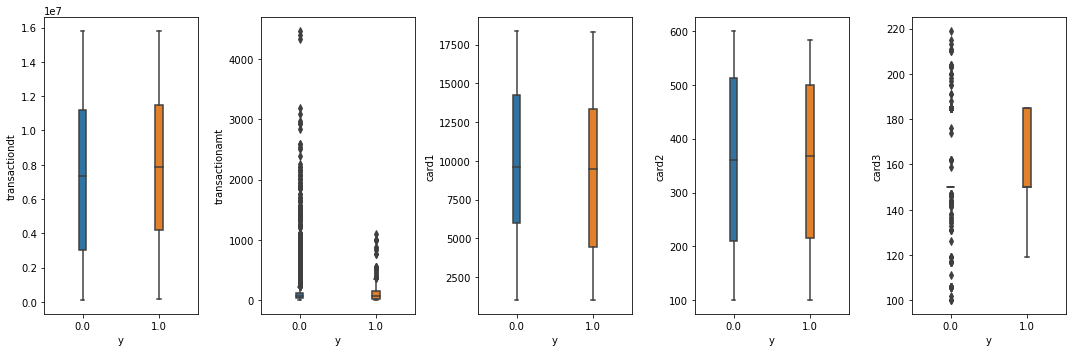

In [94]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*0:partition*1]], y_train['y'], '01')

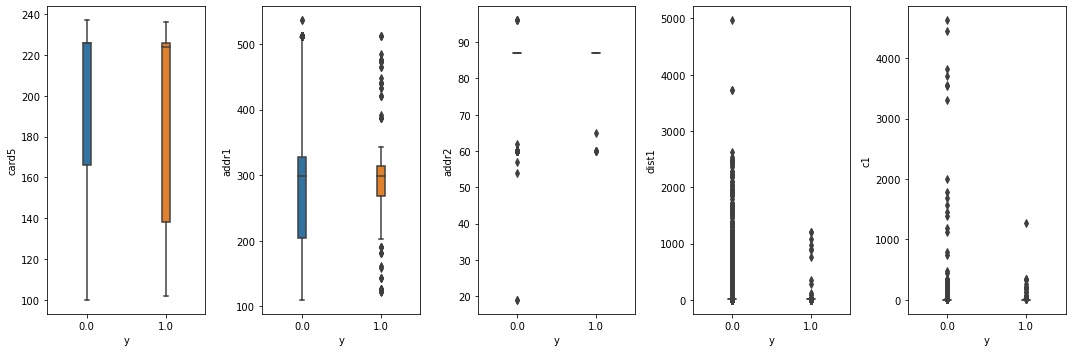

In [95]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*1:partition*2]], y_train['y'], '02')

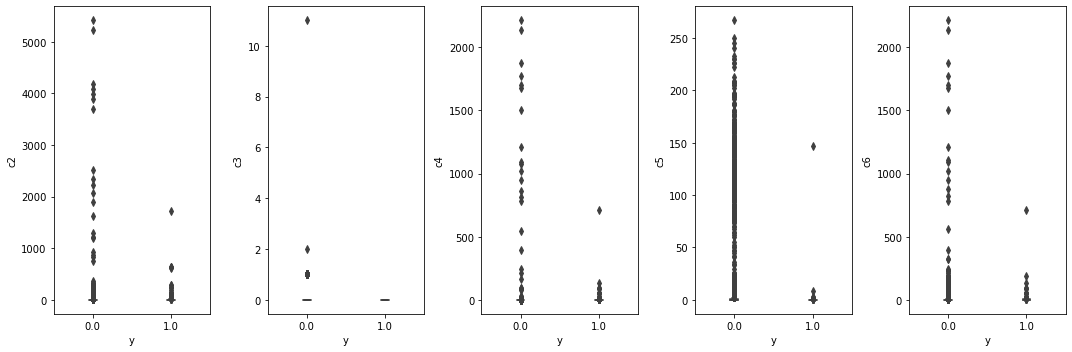

In [96]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*2:partition*3]], y_train['y'], '03')

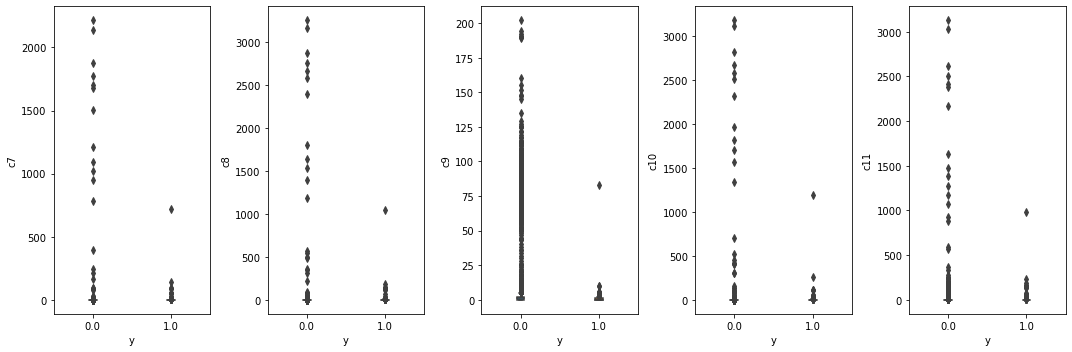

In [97]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*3:partition*4]], y_train['y'], '04')

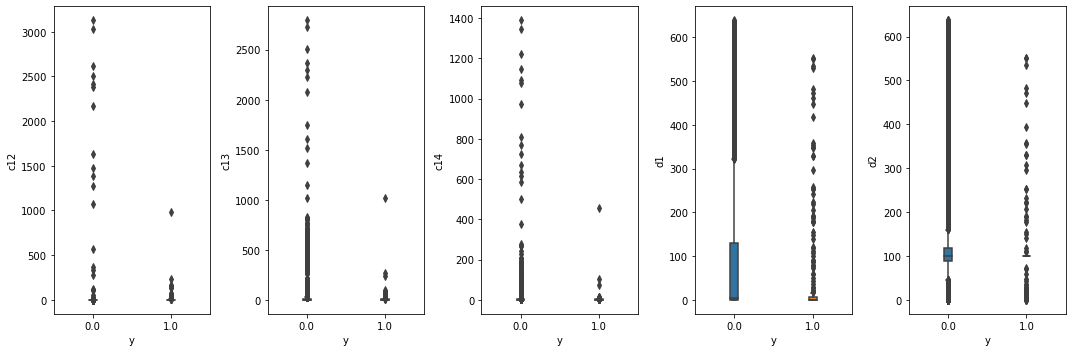

In [99]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*4:partition*5]], y_train['y'], '05')

# <a id="evaluate categorical features">evaluate categorical features</a>

In [58]:
categories_dict = {}
for cat in data.columns:
    if data[cat].dtypes == 'object':
        categories_dict[cat] = list(data[cat].unique())
        n_categories = data[cat].unique().size
        print("number of categories for variable '{}': {} ".format(cat, n_categories))

number of categories for variable 'productcd': 5 
number of categories for variable 'card4': 5 
number of categories for variable 'card6': 3 
number of categories for variable 'p_emaildomain': 55 
number of categories for variable 'r_emaildomain': 41 
number of categories for variable 'm4': 4 


# distribution of categorical vars
By assessing the proportion of positive cases over the categorical variables, we can observe some interesting factors:
* Except for the variable "multiplelines", the proportion might vary a lot according to the specific category.
* For internet service, the fiber optic users have a higher proclivity to churn.
* month-to-month users have a high chance to churn (40%). 2 years contracts have extremely low churn (just 7%).
* for payment method, payment checks users also might churn more frequently.

In [100]:
def get_cat_vis(df, cat, y):
    df = df.copy()
    df['y'] = y
    print('selected feature:', feature)
    print('proportion of positive cases')
    multiplers = (df[df['y']==1][cat].value_counts() / df[cat].value_counts()).sort_values(ascending=False).head()
    print(multiplers)
    sns.catplot(x=cat, kind="count", hue="y", data=df, height=4);

In [101]:
print('there are {} categorical variables'.format(len(categories_dict.keys())))
print('from a total of {}'.format(data.shape[1]))

there are 6 categorical variables
from a total of 46


In [61]:
# cat = cat_list[0]
# plt.xticks(rotation=45)
# data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

In [62]:
cat_list = list(categories_dict.keys())

selected feature: productcd
proportion of positive cases
C    0.131920
S    0.093750
R    0.038031
H    0.029491
W    0.021142
Name: productcd, dtype: float64


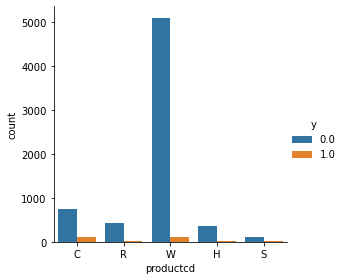

In [102]:
feature = cat_list[0]
get_cat_vis(data, feature, y_train['y'])

selected feature: card4
proportion of positive cases
discover            0.105882
mastercard          0.042241
visa                0.034385
american express    0.010000
Name: card4, dtype: float64


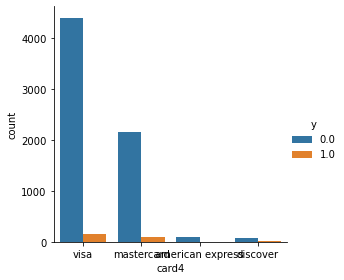

In [103]:
feature = cat_list[1]
get_cat_vis(data, feature, y_train['y'])

selected feature: card6
proportion of positive cases
credit    0.069500
debit     0.026811
Name: card6, dtype: float64


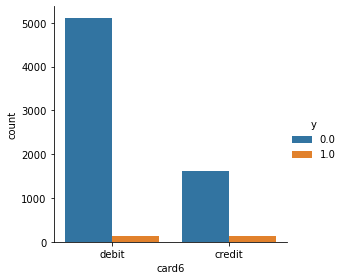

In [104]:
feature = cat_list[2]
get_cat_vis(data, feature, y_train['y'])

selected feature: p_emaildomain
proportion of positive cases
mail.com       0.600000
outlook.es     0.500000
aim.com        0.200000
ymail.com      0.107143
outlook.com    0.100000
Name: p_emaildomain, dtype: float64


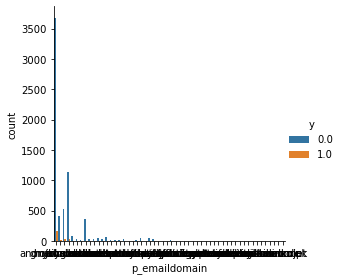

In [105]:
feature = cat_list[3]
get_cat_vis(data, feature, y_train['y'])

selected feature: r_emaildomain
proportion of positive cases
mail.com       1.000000
ymail.com      0.500000
outlook.es     0.500000
outlook.com    0.294118
icloud.com     0.125000
Name: r_emaildomain, dtype: float64


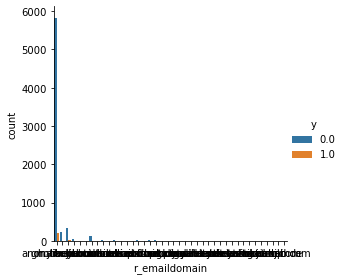

In [106]:
feature = cat_list[4]
get_cat_vis(data, feature, y_train['y'])

selected feature: m4
proportion of positive cases
M2    0.123847
M0    0.027219
M1    0.024194
Name: m4, dtype: float64


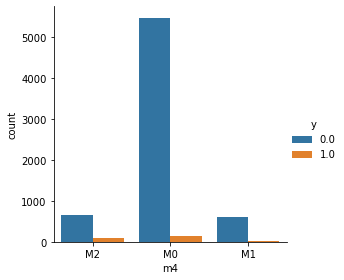

In [107]:
feature = cat_list[5]
get_cat_vis(data, feature, y_train['y'])

# distribution of boolean vars


selected feature: m1
proportion of positive cases
1.0    0.037434
0.0         NaN
Name: m1, dtype: float64


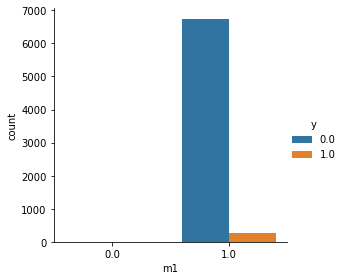

In [109]:
feature = boolean_vars[0]
get_cat_vis(data, feature, y_train['y'])

selected feature: m2
proportion of positive cases
1.0    0.038029
0.0    0.028169
Name: m2, dtype: float64


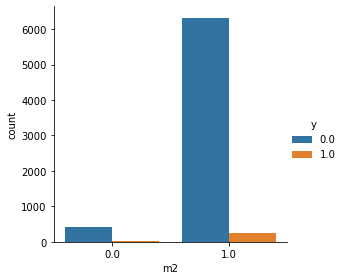

In [110]:
feature = boolean_vars[1]
get_cat_vis(data, feature, y_train['y'])

selected feature: m3
proportion of positive cases
1.0    0.039577
0.0    0.022093
Name: m3, dtype: float64


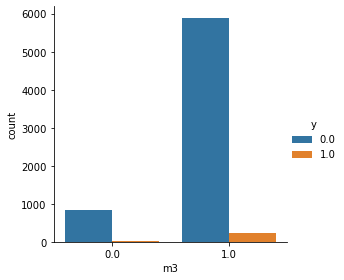

In [111]:
feature = boolean_vars[2]
get_cat_vis(data, feature, y_train['y'])

selected feature: m5
proportion of positive cases
1.0    0.039937
0.0    0.036869
Name: m5, dtype: float64


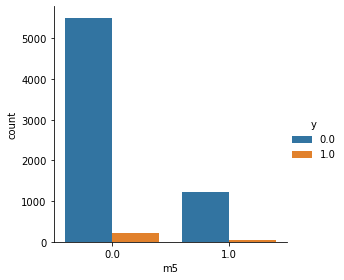

In [112]:
feature = boolean_vars[3]
get_cat_vis(data, feature, y_train['y'])

selected feature: m6
proportion of positive cases
0.0    0.047031
1.0    0.017818
Name: m6, dtype: float64


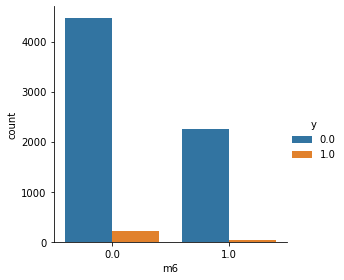

In [113]:
feature = boolean_vars[4]
get_cat_vis(data, feature, y_train['y'])

selected feature: m7
proportion of positive cases
0.0    0.038450
1.0    0.020305
Name: m7, dtype: float64


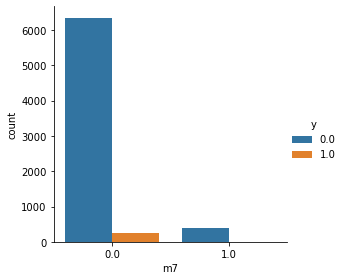

In [114]:
feature = boolean_vars[5]
get_cat_vis(data, feature, y_train['y'])

selected feature: m8
proportion of positive cases
0.0    0.040228
1.0    0.021277
Name: m8, dtype: float64


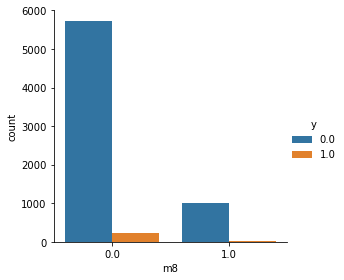

In [115]:
feature = boolean_vars[6]
get_cat_vis(data, feature, y_train['y'])

selected feature: m9
proportion of positive cases
1.0    0.037938
0.0    0.030238
Name: m9, dtype: float64


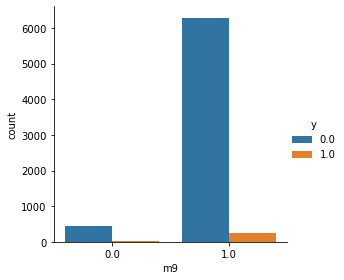

In [116]:
feature = boolean_vars[7]
get_cat_vis(data, feature, y_train['y'])

# <a id="missing data">missing data</a>

usually, missing data is solved by filling it with some metric such as median. If the number of missing data in some entry is too high, we must evaluate for the removal of those entries.
For categorical with missing data, if you want to encode missing values, first change its type to a string:
```python
a[pd.isnull(a)]  = 'NaN'
```
Some refs:
* https://stackoverflow.com/questions/36808434/label-encoder-encoding-missing-values

About the missing values, we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Further investigation would be necessary to properly decide over how to handle it.

For now, I am assuming they are Missing at Random. So I will remove some of them through a threshold, and apply imputation for the rest. By applying a proper imputation I observed a slight improvement over the score.

The catch is that applying imputation over euclidean distances can be extremely imprecise.

### drop columns and rows for threshold of missing

In [63]:
print('SORTED LIST OF MISSING VALUES')
data_missing = get_missing(data)
data_missing_vis = data_missing[data_missing['total'] > 0]
data_missing_vis['percent_missing'] = data_missing_vis['percent_missing'].apply(lambda x: round(x, 2))
# data_missing_vis.sort_values(by='percent_missing', ascending=False).head(20)
data_missing_vis.sort_values(by='percent_missing', ascending=False)

SORTED LIST OF MISSING VALUES


,total,percent_missing
d7,6539,0.93
dist2,6522,0.93
d14,6267,0.90
d13,6263,0.89
d12,6203,0.89
d6,6118,0.87
d9,6094,0.87
d8,6094,0.87
r_emaildomain,5353,0.76
m5,4171,0.60


In [64]:
col_mis_threshold = 0.8
row_mis_threshold = 0.5

In [65]:
removed_cols = data_missing_vis[data_missing_vis['percent_missing'] > col_mis_threshold].index
data = drop_missing_from_threshold(data, data_missing, row_mis_threshold, col_mis_threshold)

0 rows and 8 columns were removed from database


### visualize rows with missing
we already know that the critical columns are related to geo_location

In [66]:
# sandbox_mode = True
if sandbox_mode:
    print('number of missing:', data[data.isna().any(axis=1)].shape[0])
    data[data.isna().any(axis=1)].tail()

### imputation of missing values
For continuous values, I would prefer knn over median, but it depends on normalized dataset. Nevertheless, we don't have missing on continuous datasets, even though we could encode categorical data. But the encoding step wasn't organized to precede this notebook, so I will stick to 'mode', which imputes the most frequent value.

Some refs:
* https://jamesrledoux.com/code/imputation#:~:text=One%20approach%20to%20imputing%20categorical,given%20in%20Pandas'%20value_counts%20function.

the apply_imputation function accepts the following methods: knn, median, mode, or -1 (impute as category -1 [for categorical vars])

In [67]:
for c in removed_cols:
    numerical_cols.remove(c)

In [68]:
# imputation over numerical variables
data[numerical_cols] = data[numerical_cols].astype(float)
if data[numerical_cols].isnull().values.any():
#     data[numerical_cols] = apply_imputation(data[numerical_cols], method = 'knn', k = 30)
    data[numerical_cols] = apply_imputation(data[numerical_cols], method = 'median', k = 30)

# imputation over categorical variables
# if data[other_cols].isnull().values.any():
data[other_cols] = apply_imputation(data[other_cols], method = 'mode', k = 30)

# manual imputation on lag and forecast variables
# manual_cols = ['lag_1', 'lag_2', 'lag_3']
# if data[manual_cols].isnull().values.any():
#     data[manual_cols] = apply_imputation(data[manual_cols], method = 'manual', manual_val = False)
# data_test['y'].fillna(value=data_test['y'], inplace=True)

In [69]:
# imputation over numerical variables
data_test[numerical_cols] = data_test[numerical_cols].astype(float)
if data_test[numerical_cols].isnull().values.any():
#     data_test[numerical_cols] = apply_imputation(data_test[numerical_cols], method = 'knn', k = 30)
    data_test[numerical_cols] = apply_imputation(data_test[numerical_cols], method = 'median', k = 30)

# imputation over categorical variables
if data_test[other_cols].isnull().values.any():
    data_test[other_cols] = apply_imputation(data_test[other_cols], method = 'mode', k = 30)

# <a id="anomaly detection">anomaly detection</a>

remove outliers from choosing one of the following methods: isolation_forest, standard_deviation_tol (using z_score on standardized version)

other parameters are:
* if_contamination: isolation forest level of contamination
* z_tol: tolerance for standard deviation (if using zscore)

It is not advisable to remove outliers without proper consideration.

Some interesting refs:
* https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
* https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

In [70]:
# temporarily add train to test data (no leakage here)
test_start = data_test.index[0]
data_test = data.append(data_test)

# get outliers on train data
data['if_anomaly'], _ = get_outliers(data[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)

# get outliers on test data (needs trainset)

data_test['if_anomaly'], _ = get_outliers(data_test[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)

# removes trainset again
data_test = data_test.iloc[len(data):,:]

number of outliers: 350 from a total of 7000
percentage of outliers: 5%
number of outliers: 500 from a total of 10000
percentage of outliers: 5%


outlier removal isn't justified for now

In [71]:
remove_outliers = False

In [72]:
if remove_outliers:
    data = data[data['if_anomaly'] == 1]
    y_train = y_train[y_train.index.isin(data.index.to_list())]

# build new variables

# <a id="Visualize pairwise relations">Visualize pairwise relations</a>
When datasets have just a few variables (10–15), pairplots allow for a quick visual inspection of those relations, as well as bariable distributions.

In [73]:
numerical_cols, other_cols = get_numerical_mask(data)

boolean_vars = []
boolean_vars.append('if_anomaly')
for col in boolean_vars:
    numerical_cols.remove(col)

In [123]:
separator = int(len(numerical_cols)/5)

In [124]:
separator

6

#### group 1

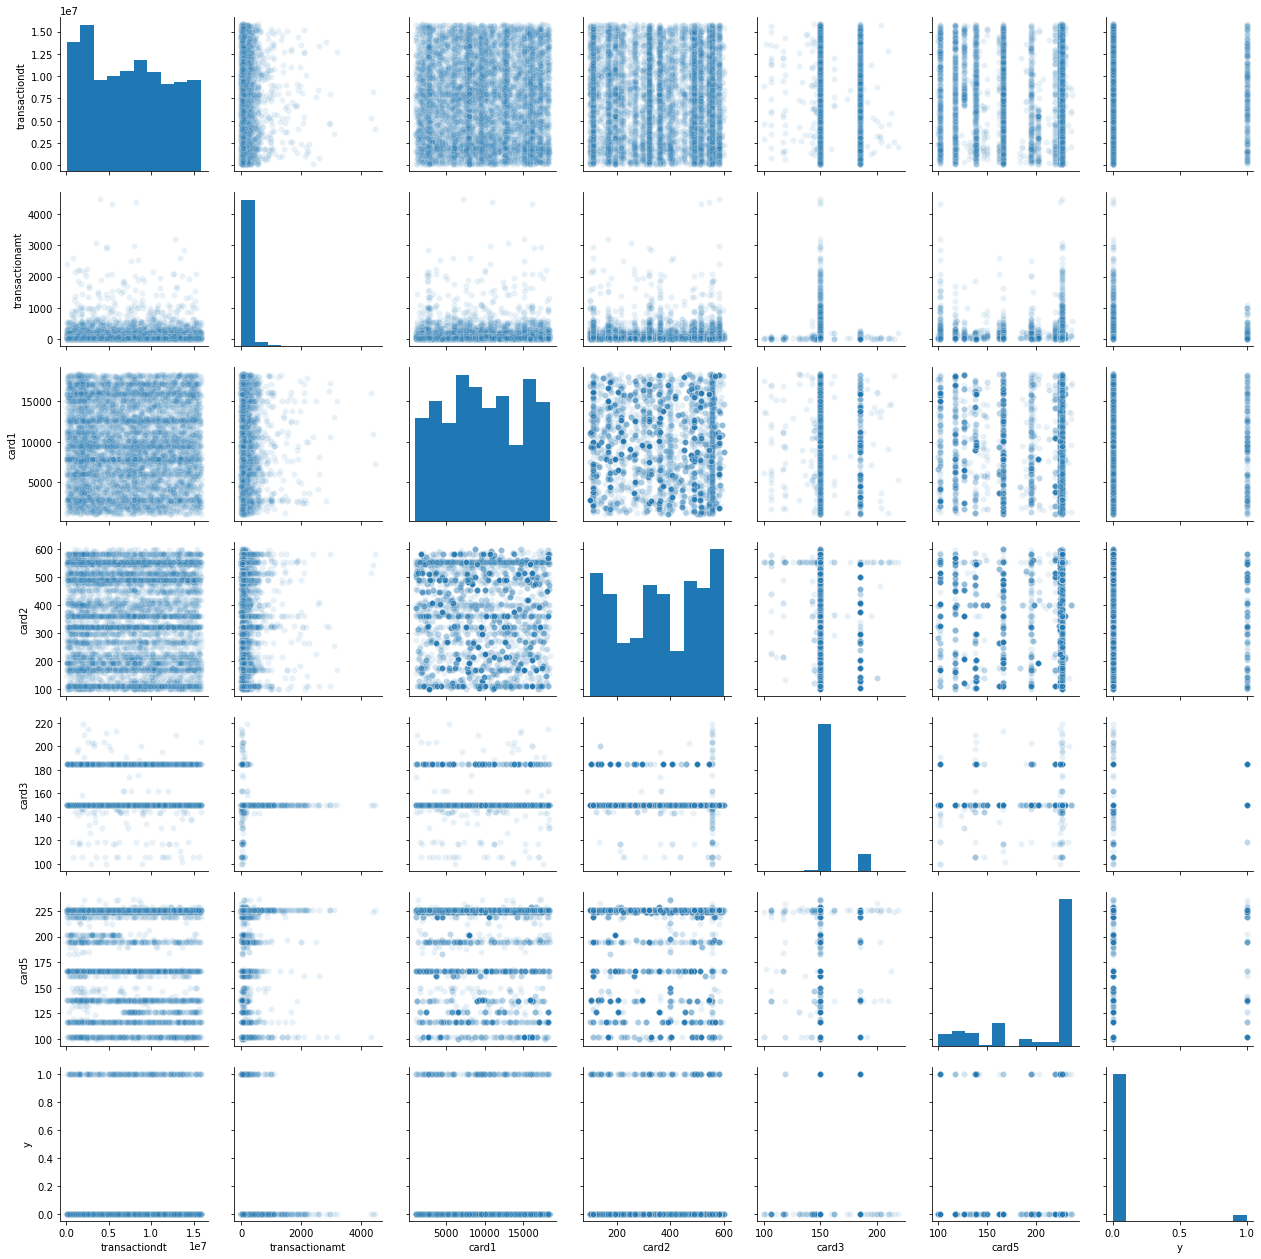

In [125]:
if not sandbox_mode:
    data_vis = data[numerical_cols[:separator]]
    data_vis['y'] = y_train['y']
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots_1.jpg'), bbox_inches = "tight")

#### group 2

# check selected distributions

In [77]:
y = y_train['y']

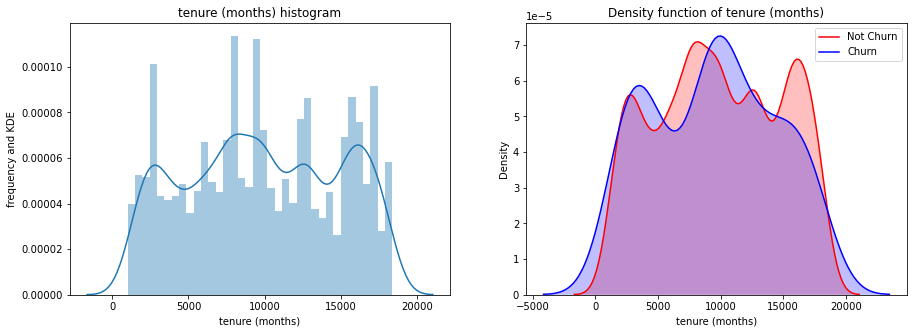

In [118]:
var_name = 'card1'
plot_dist(data[var_name], y, var_name, xlabel = 'tenure (months)')

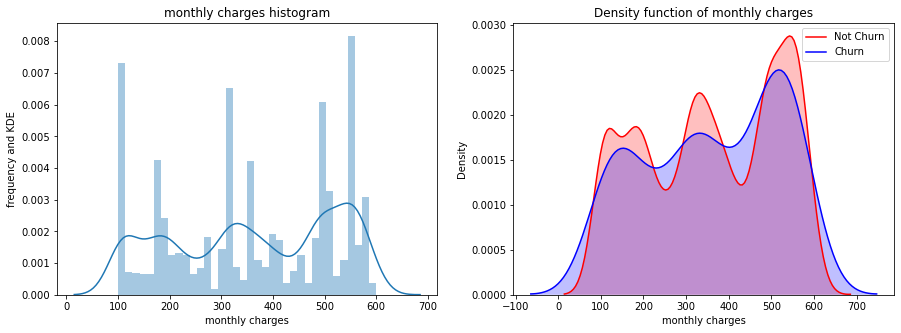

In [119]:
var_name = 'card2'
plot_dist(data[var_name], y, var_name, xlabel = 'monthly charges')

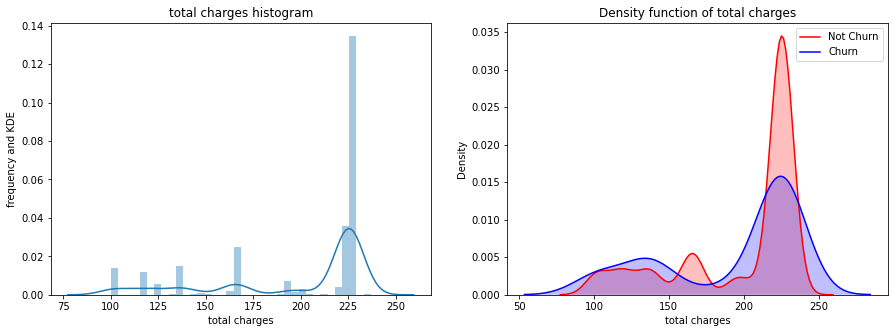

In [121]:
var_name = 'card5'
plot_dist(data[var_name], y, var_name, xlabel = 'total charges')

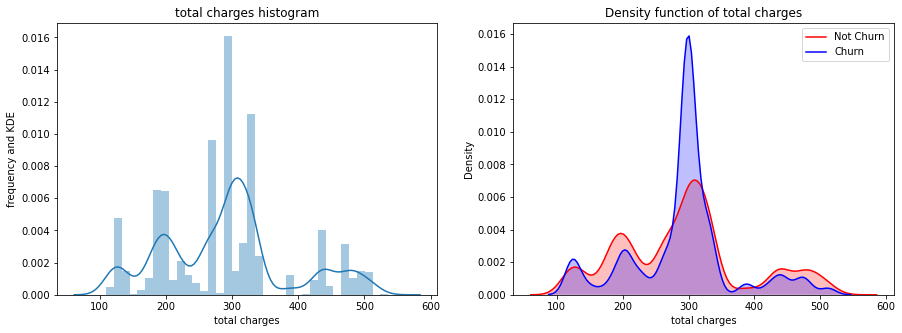

In [122]:
var_name = 'addr1'
plot_dist(data[var_name], y, var_name, xlabel = 'total charges')

# <a id="Check if data is imbalanced">Check if data is imbalanced</a>
When data is imbalanced, we must evaluate for solutions such as oversampling or undersamplig, which might be done with techniques such as SMOTE (Synthetic Minority Oversampling Technique).

In [ ]:
y = y_train.append(y_test)

In [ ]:
color = sns.color_palette()
classif = y_train['y'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Failed', fontsize=12)
plt.plot()
plt.savefig(os.path.join(reports,'imbalance.jpg'), bbox_inches = "tight")

In [ ]:
counts = y['y'].value_counts()
counts

In [ ]:
print('ratio between classes:',round(counts[0]/counts[1],2))
print('\r\nCheck proportions below:')
y['y'].value_counts(normalize=True)

# Description (2nd round)

In [ ]:
if sandbox_mode:
    print(data.shape[0])
    print(y_train.shape[0])
    print(data_test.shape[0])
    print(y_test.shape[0])
    data.describe()

# save intermediate data

In [ ]:
data.to_csv(os.path.join(outputs, 'X_train.csv'))
data_test.to_csv(os.path.join(outputs, 'X_test.csv'))

y_train.to_csv(os.path.join(outputs, 'y_train.csv'))
y_test.to_csv(os.path.join(outputs, 'y_test.csv'))